## 1. Configurando ambiente

### 1.1. Instalando Pacotes

In [ ]:
!pip install s3fs xarray[complete] cartopy metpy --quiet
!pip install seaborn --quiet

### 1.2. Importando Bibliotecas

In [ ]:
import os
import gc
import sys
from io import BytesIO
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import cartopy
import metpy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER as LongitudeFormatter
from cartopy.mpl.gridliner import LATITUDE_FORMATTER as LatitudeFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16,
        }
matplotlib.rc('font', **font)

from scipy.interpolate import griddata

import glob
import math
from pyproj import Proj
from geographiclib.geodesic import Geodesic

## 2. Teste com bibliotecas de geoprocessamento e GOES

noaa-goes16/ABI-L2-LSTF/2022/225/15/OR_ABI-L2-LSTF-M6_G16_s20222251500207_e20222251509515_c20222251511340.nc
<class 'str'>
<File-like object S3FileSystem, noaa-goes16/ABI-L2-LSTF/2022/225/15/OR_ABI-L2-LSTF-M6_G16_s20222251500207_e20222251509515_c20222251511340.nc>
(1086,)
(1086,)
(1086, 1086)


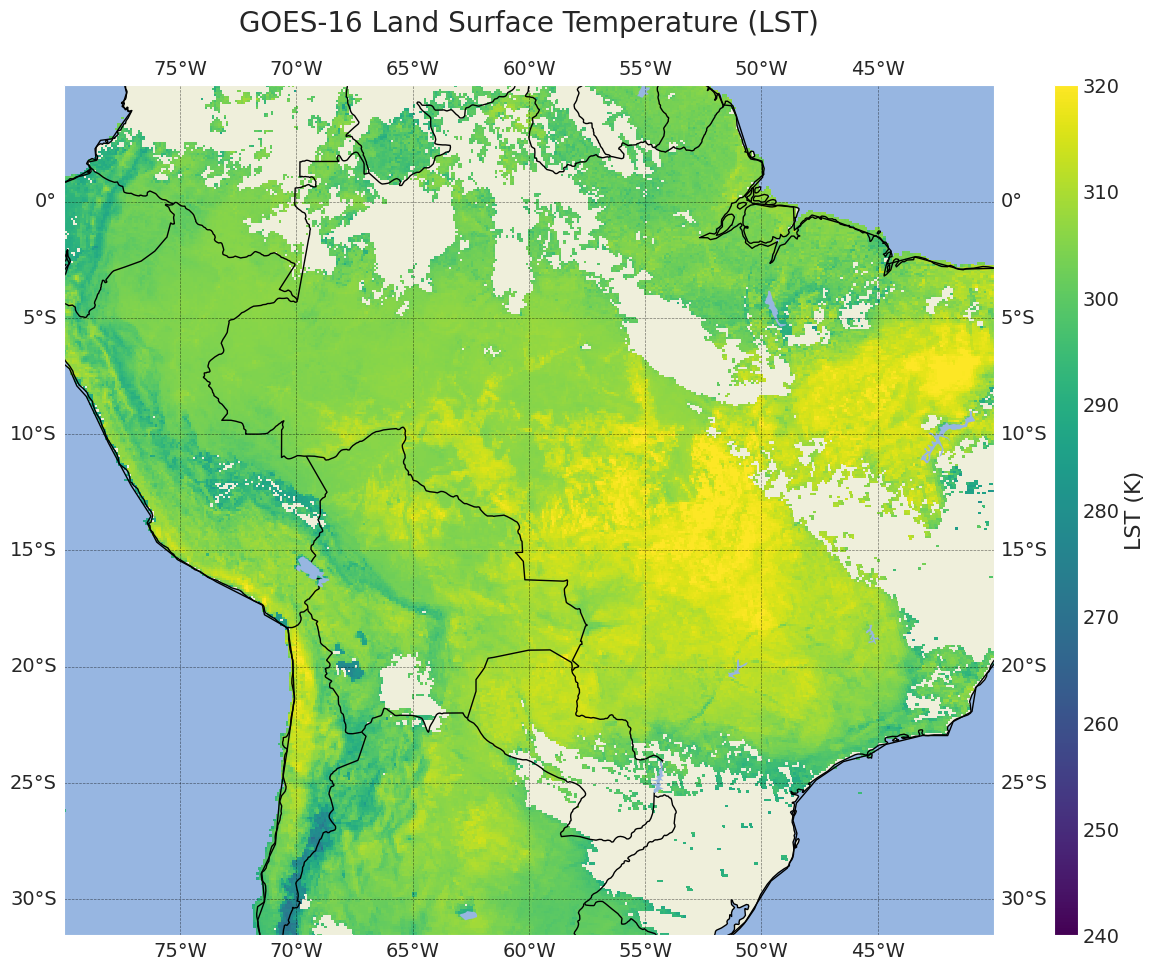

In [ ]:
fs = s3fs.S3FileSystem(anon=True)

newproj = ccrs.PlateCarree()
geo = ccrs.Geodetic()

files = fs.ls('noaa-goes16/ABI-L2-LSTF/2022/225/15')
print(files[0])
print(type(files[0]))

with fs.open(files[0], 'rb') as f:
  print(f)
  ds = xr.open_dataset(BytesIO(f.read()), engine='h5netcdf')
  sat_h = ds.goes_imager_projection.perspective_point_height #coletando altura do satelite
  sat_lon = ds.goes_imager_projection.longitude_of_projection_origin #coletando longitude do satelite (fixa)
  sat_sweep = ds.goes_imager_projection.sweep_angle_axis[0] #coletando angulo de varredura para
  oproj=ccrs.Geostationary(central_longitude=sat_lon,satellite_height=sat_h,sweep_axis=sat_sweep) #criando projecao

  X = np.array(ds.x) * sat_h
  Y = np.array(ds.y) * sat_h
  temp = np.array(ds.LST) #armazendando temperatura

  print(X.shape)
  print(Y.shape)
  print(temp.shape)
  #lst = ds['LST']
  #lst_values = lst.values

  fig = plt.figure(num=1,figsize=(12, 12))
  ax = fig.add_subplot(1, 1, 1, projection=newproj)
  im = ax.pcolormesh(X, Y, temp, transform=oproj, cmap='viridis', vmin=240,vmax=320)

  minlon, maxlon, minlat, maxlat = -80,-40,-30,5

  ax.coastlines(resolution='110m')
  ax.add_feature(cartopy.feature.LAND)
  ax.add_feature(cartopy.feature.OCEAN)
  ax.add_feature(cartopy.feature.COASTLINE,linewidth=1.0)
  ax.add_feature(cartopy.feature.BORDERS, linestyle='-',linewidth=1.0)
  ax.add_feature(cartopy.feature.LAKES)
  ax.set_extent([minlon, maxlon, minlat, maxlat], crs=geo)

  gl=ax.gridlines(crs=newproj,draw_labels=True,linewidth=0.5, color='black', alpha=0.5, linestyle='--')
  gl.xlabels_top=False
  gl.ylabels_right=False
  gl.xformatter = LongitudeFormatter
  gl.yformatter = LatitudeFormatter
  gl.xlabel_style = {'size': 14}
  gl.ylabel_style = {'size': 14}

  cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
  cb = fig.colorbar(im,cax=cax, orientation="vertical", shrink=0.7,pad=0.02)
  #cb.ax.set_yticklabels(ticklabellist[j])
  cb.ax.tick_params(size=0,labelsize=14)
  cb.set_label('LST (K)', fontsize=16)

  ax.set_title('GOES-16 Land Surface Temperature (LST)', fontsize=20, pad=20)

  plt.show()

#display(ds.LST)

['noaa-goes16/ABI-L2-LST2KMF/2022/225/15/OR_ABI-L2-LST2KMF-M6_G16_s20222251500207_e20222251509515_c20222251511341.nc']


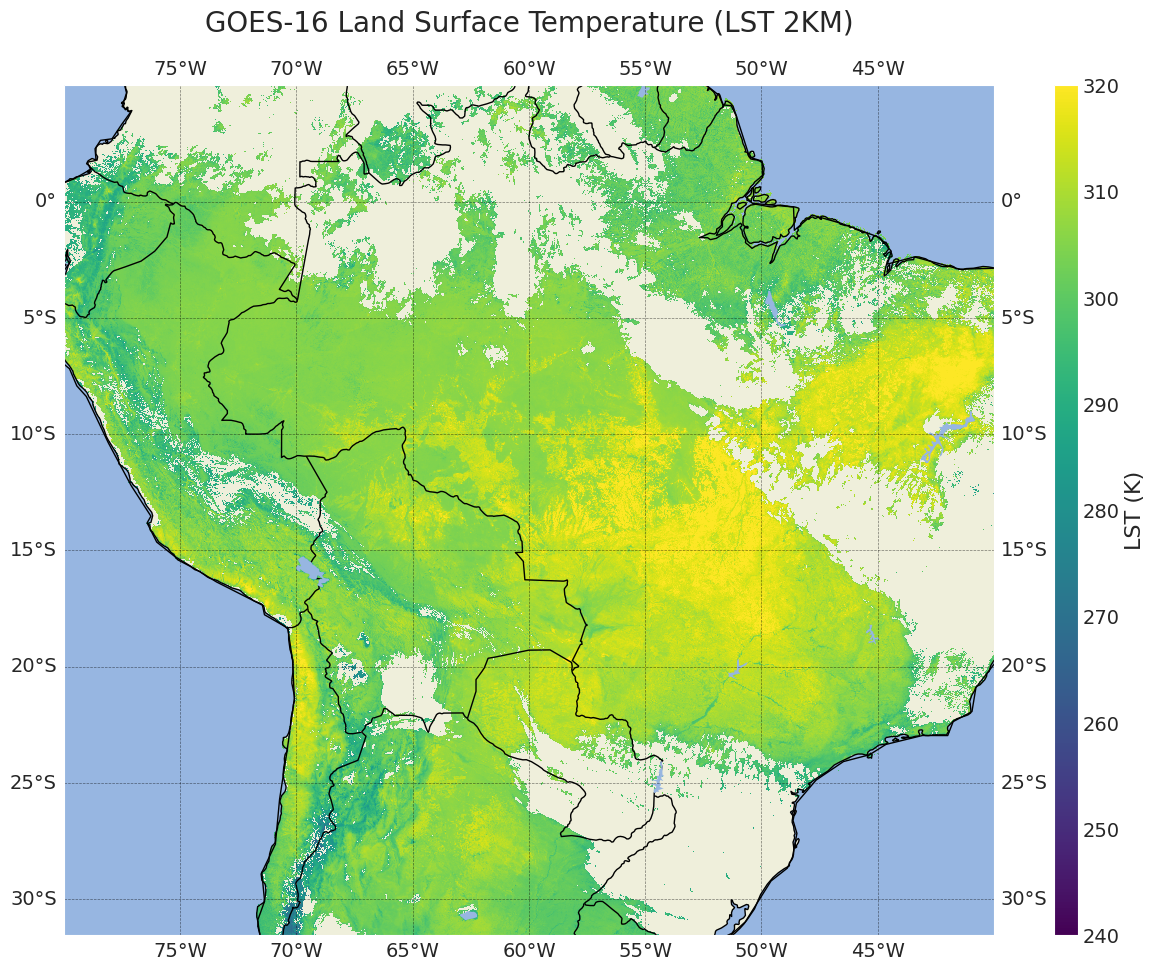

In [ ]:
fs = s3fs.S3FileSystem(anon=True)

newproj = ccrs.PlateCarree()
geo = ccrs.Geodetic()


files = fs.ls('noaa-goes16/ABI-L2-LST2KMF/2022/225/15')
print(files)

with fs.open(files[0], 'rb') as f:
    ds = xr.open_dataset(BytesIO(f.read()), engine='h5netcdf')
    sat_h = ds.goes_imager_projection.perspective_point_height #coletando altura do satelite
    sat_lon = ds.goes_imager_projection.longitude_of_projection_origin #coletando longitude do satelite (fixa)
    sat_sweep = ds.goes_imager_projection.sweep_angle_axis[0] #coletando angulo de varredura para
    oproj=ccrs.Geostationary(central_longitude=sat_lon,satellite_height=sat_h,sweep_axis=sat_sweep) #criando projecao

    X = np.array(ds.x) * sat_h
    Y = np.array(ds.y) * sat_h
    temp = np.array(ds.LST) #armazendando temperatura

    #lst = ds['LST']
    #lst_values = lst.values

    fig = plt.figure(num=1,figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1, projection=newproj)
    im = ax.pcolormesh(X, Y, temp, transform=oproj, cmap='viridis', vmin=240,vmax=320)

    minlon, maxlon, minlat, maxlat = -80,-40,-30,5

    ax.coastlines(resolution='110m')
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=1.0)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-',linewidth=1.0)
    ax.add_feature(cartopy.feature.LAKES)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=geo)

    gl=ax.gridlines(crs=newproj,draw_labels=True,linewidth=0.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter = LongitudeFormatter
    gl.yformatter = LatitudeFormatter
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
    cb = fig.colorbar(im,cax=cax, orientation="vertical", shrink=0.7,pad=0.02)
    #cb.ax.set_yticklabels(ticklabellist[j])
    cb.ax.tick_params(size=0,labelsize=14)
    cb.set_label('LST (K)', fontsize=16)

    ax.set_title('GOES-16 Land Surface Temperature (LST 2KM)', fontsize=20, pad=20)

    plt.show()

#display(ds.LST)

302.195068359375
{'long_name': 'ABI L2+ Land Surface (Skin) Temperature', 'standard_name': 'surface_temperature', 'valid_range': array([ 9200, 61200], dtype=uint16), 'units': 'K', 'resolution': 'y: 0.000056 rad x: 0.000056 rad', 'grid_mapping': 'goes_imager_projection', 'cell_methods': 'retrieval_local_zenith_angle: point (good or degraded quality pixel produced) quantitative_local_zenith_angle: point (good quality pixel produced) solar_zenith_angle: point (good quality pixel produced) t: point area: point where land', 'ancillary_variables': 'DQF'}


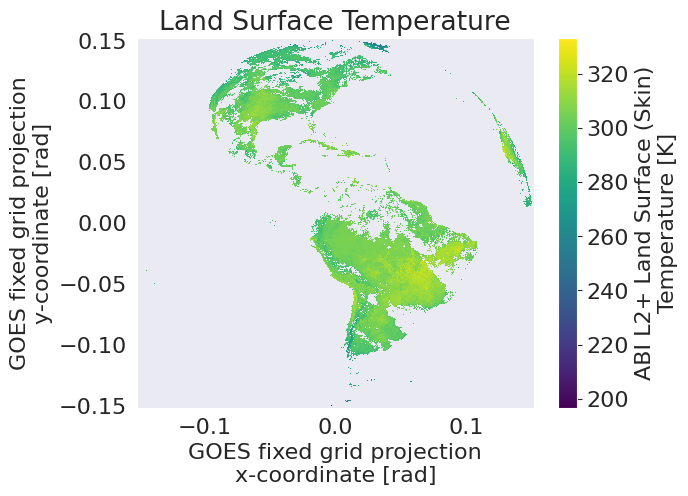

In [ ]:
lst = ds['LST'] #Other way to access LST data through AWS files

mean_lst = lst.mean()
print(mean_lst.item())
print(lst.attrs)


lst.plot()
plt.title("Land Surface Temperature")
plt.show()

##3. Definições de Padrões

### 3.1. Função getgoes

A função 'getgoes' recebe o nome do arquivo e o campo de dados que queremos extrair. Ela normaliza o referencial para sair do satélite e visualizarmos a partir de um referencial na terra, no sentido onde o centro da Terra e a região de interesse se alinhem radialmente.

In [ ]:
def getgoes(fname,field):
    with fs.open(fname, 'rb') as f:
        ds = xr.open_dataset(BytesIO(f.read()), engine='h5netcdf')
        sat_h = ds.goes_imager_projection.perspective_point_height #coletando altura do satelite
        sat_lon = ds.goes_imager_projection.longitude_of_projection_origin #coletando longitude do satelite (fixa)
        sat_sweep = ds.goes_imager_projection.sweep_angle_axis[0] #coletando angulo de varredura para
        oproj=ccrs.Geostationary(central_longitude=sat_lon,satellite_height=sat_h,sweep_axis=sat_sweep) #criando projecao
        p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

        X = np.array(ds.x) * sat_h
        Y = np.array(ds.y) * sat_h
        data = np.array(ds[field]) #armazendando dados


    # # Convert map points to latitude and longitude
    XX, YY = np.meshgrid(X, Y)
    rlon, rlat = p(XX, YY, inverse=True)
    rlat[np.isnan(data)] = np.nan
    rlon[np.isnan(data)] = np.nan

    ds.close()

    return rlat, rlon, data



### 3.2. Definindo nossa caixa que contém região de interesse

Foi usado a função 'getgoes' para um dia completamente limpo e sem nuvens. O valor 'vnum' é pego para definir o número máximo de pixeis úteis na nossa região de interesse e, assim, podemos comparar com outros dias e entender se a aferência daquele dia é estatísticamente interessante ou não.

In [ ]:
lat, lon, data = getgoes(files[0], "LST")

# Lat/Lon coordinates
# Coordinates for middle of Ribeirao Preto
latsite = -21.12
lonsite = -47.48

# Box side length in km. E.g. 100 means a 100 x 100 km² box (~1 x 1 deg)
boxsize = 200

geod   = Geodesic.WGS84  # define the WGS84 ellipsoid
north  = geod.Direct(latsite, lonsite,  0.0, boxsize/2.*1e3) #calculating box from its center defined by latsite and lonsite
east   = geod.Direct(latsite, lonsite, 90.0, boxsize/2.*1e3)
south  = geod.Direct(latsite, lonsite, 180.0, boxsize/2.*1e3)
west   = geod.Direct(latsite, lonsite, 270.0, boxsize/2.*1e3)
minlat = np.min([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
maxlat = np.max([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
minlon = np.min([north['lon2'],east['lon2'],south['lon2'],west['lon2']])
maxlon = np.max([north['lon2'],east['lon2'],south['lon2'],west['lon2']])

print(f"minlat={minlat}")
print(f"maxlat={maxlat}")
print(f"minlon={minlon}")
print(f"maxlon={maxlon}")

box = (lat >= minlat) & (lat <= maxlat) & (lon >= minlon) & (lon <= maxlon)
#if np.any(box):
#    output(data[box].flatten(),sat+'-'+yy+ddd+'-'+hhmm+'-'+myvar+'.csv')

#value = np.where(data == '--', -9999, data)
#value = np.float64(nvalue)
#valid = value >= 0
#outstr = '-9999,-9999,-9999,-9999,-9999'
print(np.any(lat>=minlat))
print(np.any(lat<=maxlat))
print(np.any(lon>=minlon))
print(np.any(lon<=maxlon))

if np.any(box):
    # ESTATÍSTICA:
    vnum = str(len(data[box]))
    print(f"vnum={vnum}")
    vmin = str(np.round(np.min(data[box]), 4))
    print(f"vmin={vmin}")
    vmax = str(np.round(np.max(data[box]), 4))
    print(f"vmax={vmax}")
    vavg = str(np.round(np.average(data[box]), 4))
    print(f"vavg={vavg}")
    vstd = str(np.round(np.std(data[box]), 4))
    print(f"vstd={vstd}")
    np.histogram(data[box], bins=100)
else:
    print("No data in box")

maximum_pixel = int(vnum)
print(maximum_pixel, type(vnum))
print("shapes:")
print(box.shape)
print(lat.shape)
print(lon.shape)
print(data.shape)

minlat=-22.02314204267506
maxlat=-20.21676177358013
minlon=-48.44257190584565
maxlon=-46.51742809415435
True
True
True
True
vnum=7161
vmin=298.6675
vmax=319.1225
vavg=309.892
vstd=3.0983
7161 <class 'str'>
shapes:
(5424, 5424)
(5424, 5424)
(5424, 5424)
(5424, 5424)


### 3.3. Entendendo a distribuição de dados do dia de referência

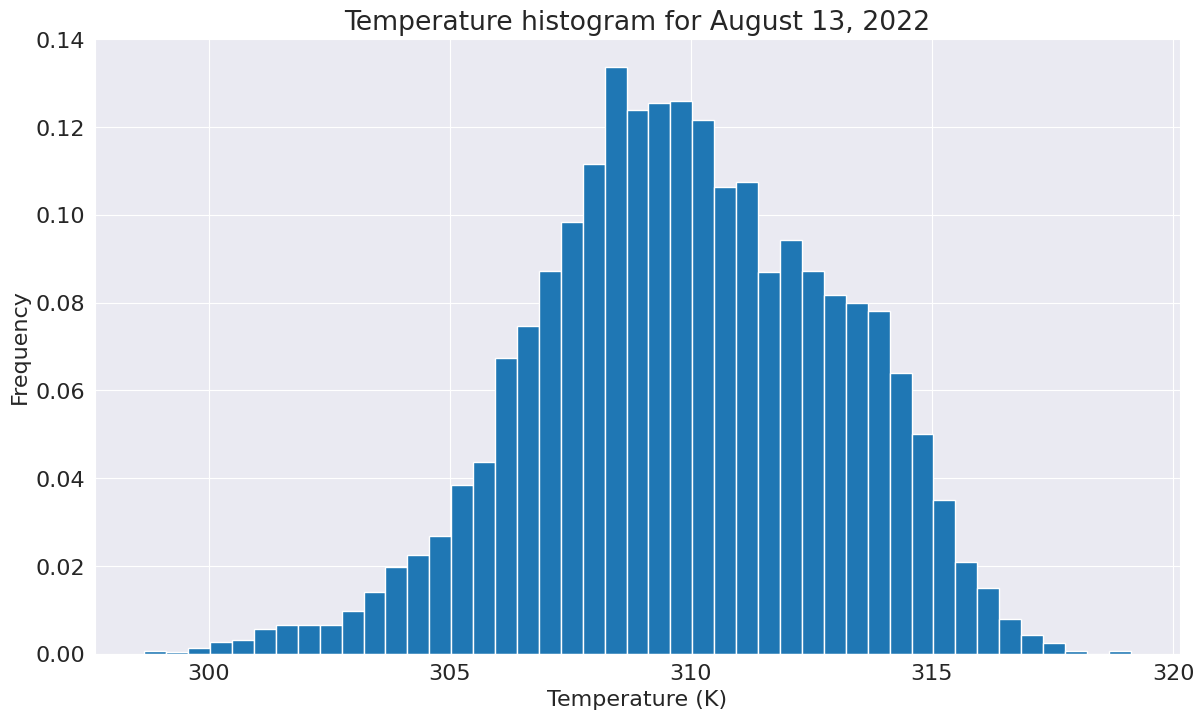

In [ ]:
plt.figure(figsize=(14, 8))
plt.hist(data[box], bins="auto", density=True)  # arguments are passed to np.histogram
plt.title("Temperature histogram for August 13, 2022")
plt.xlabel("Temperature (K)")
plt.ylabel("Frequency")
plt.show()

Variação de aprox. 15K entre temp máx e temp mínima do quadrado desse dia

In [ ]:
data_df = pd.concat([pd.DataFrame(data[box]),pd.DataFrame(lat[box]),pd.DataFrame(lon[box])], axis=1)
data_df.columns = ['lst','lat','lon']
display(data_df)
print(data_df['lst'].std())
print(data_df['lst'].mean())
print(data_df['lst'].max())
print(data_df['lst'].min())
print(data_df['lst'].median())

lst        lat        lon
0     306.052490 -20.217101 -47.109392
1     305.100006 -20.217774 -47.085766
2     304.512512 -20.218449 -47.062131
3     304.182495 -20.219124 -47.038488
4     305.482483 -20.219800 -47.014837
...          ...        ...        ...
7156  308.667480 -22.019623 -47.893131
7157  308.484985 -22.020339 -47.869424
7158  307.317505 -22.021057 -47.845711
7159  306.565002 -22.021775 -47.821988
7160  308.412506 -22.022494 -47.798256

[7161 rows x 3 columns]

3.0985240936279297
309.892
319.12249755859375
298.66748046875
309.8374938964844


In [ ]:
data_df.isna().sum()

lst    0
lat    0
lon    0
dtype: int64

Portanto, no dia 225 do ano de 2022 (13 de agosto) as 15h UTC (11h local) nós não temos nenhum dado NaN no nosso DataFrame e será nossa referência para um dia com 100% dos dados válidos.

304.7900085449219
314.82000732421875


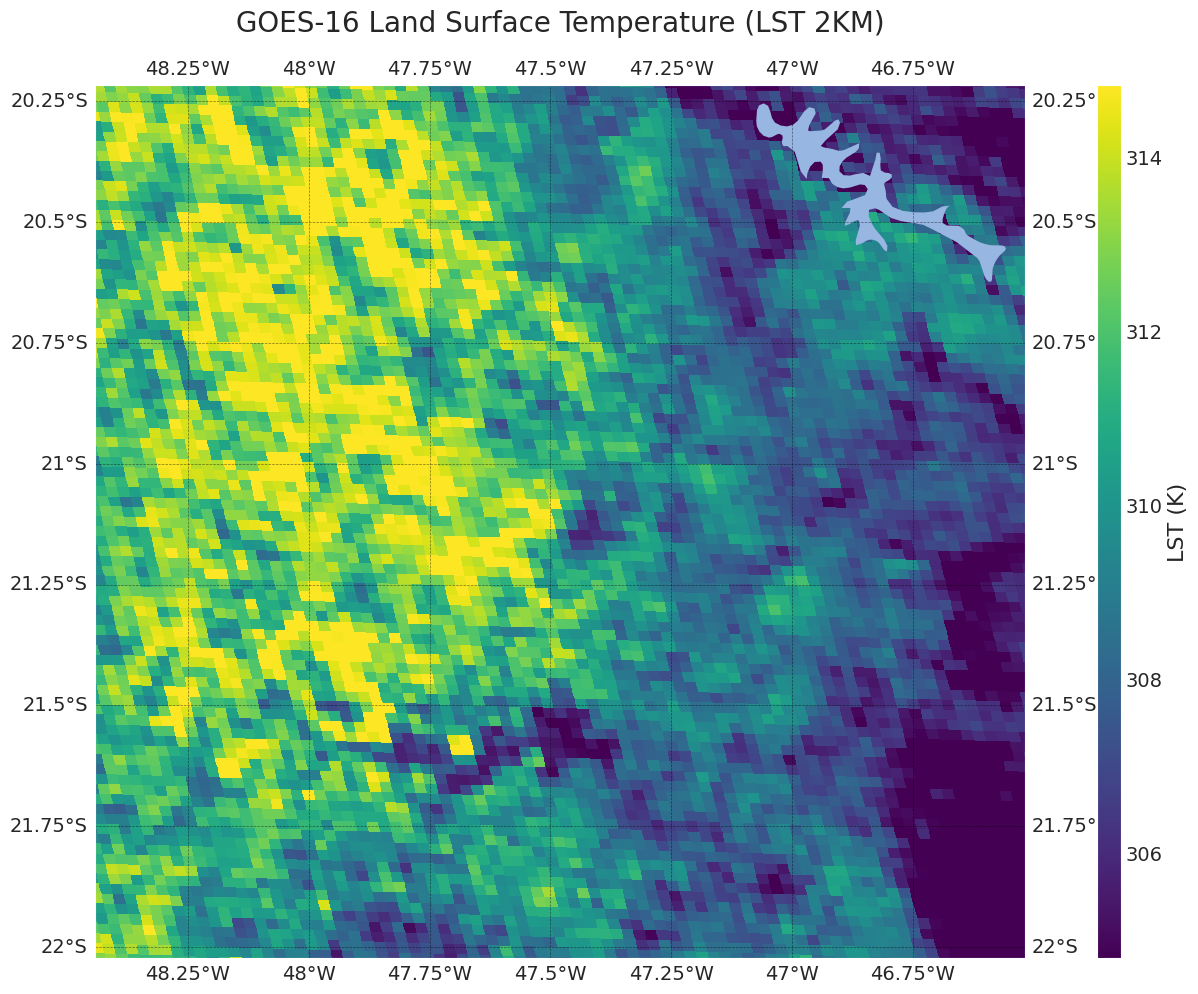

In [ ]:
with fs.open(files[0], 'rb') as f:
    ds = xr.open_dataset(BytesIO(f.read()), engine='h5netcdf')
    sat_h = ds.goes_imager_projection.perspective_point_height #coletando altura do satelite
    sat_lon = ds.goes_imager_projection.longitude_of_projection_origin #coletando longitude do satelite (fixa)
    sat_sweep = ds.goes_imager_projection.sweep_angle_axis[0] #coletando angulo de varredura para
    oproj=ccrs.Geostationary(central_longitude=sat_lon,satellite_height=sat_h,sweep_axis=sat_sweep) #criando projecao

    X = np.array(ds.x) * sat_h
    Y = np.array(ds.y) * sat_h
    temp = np.array(ds.LST) #armazendando temperatura
    vminimum = np.percentile(temp[box], 5)
    vmaximum = np.percentile(temp[box], 95)
    print(vminimum)
    print(vmaximum)

    #lst = ds['LST']
    #lst_values = lst.values

    fig = plt.figure(num=1,figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1, projection=newproj)
    im = ax.pcolormesh(X, Y, temp, transform=oproj, cmap='viridis', vmin=vminimum,vmax=vmaximum)

    ax.coastlines(resolution='110m')
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=1.0)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-',linewidth=1.0)
    ax.add_feature(cartopy.feature.LAKES)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=geo)

    gl=ax.gridlines(crs=newproj,draw_labels=True,linewidth=0.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter = LongitudeFormatter
    gl.yformatter = LatitudeFormatter
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    cb = fig.colorbar(im,cax=cax, orientation="vertical", shrink=0.7,pad=0.02)
    #cb.ax.set_yticklabels(ticklabellist[j])
    cb.ax.tick_params(size=0,labelsize=14)
    cb.set_label('LST (K)', fontsize=16)

    ax.set_title('GOES-16 Land Surface Temperature (LST 2KM)', fontsize=20, pad=20)

    plt.show()

#display(ds.LST)

In [ ]:
print(vminimum)
print(vmaximum)

304.7900085449219
314.82000732421875


Queimadas

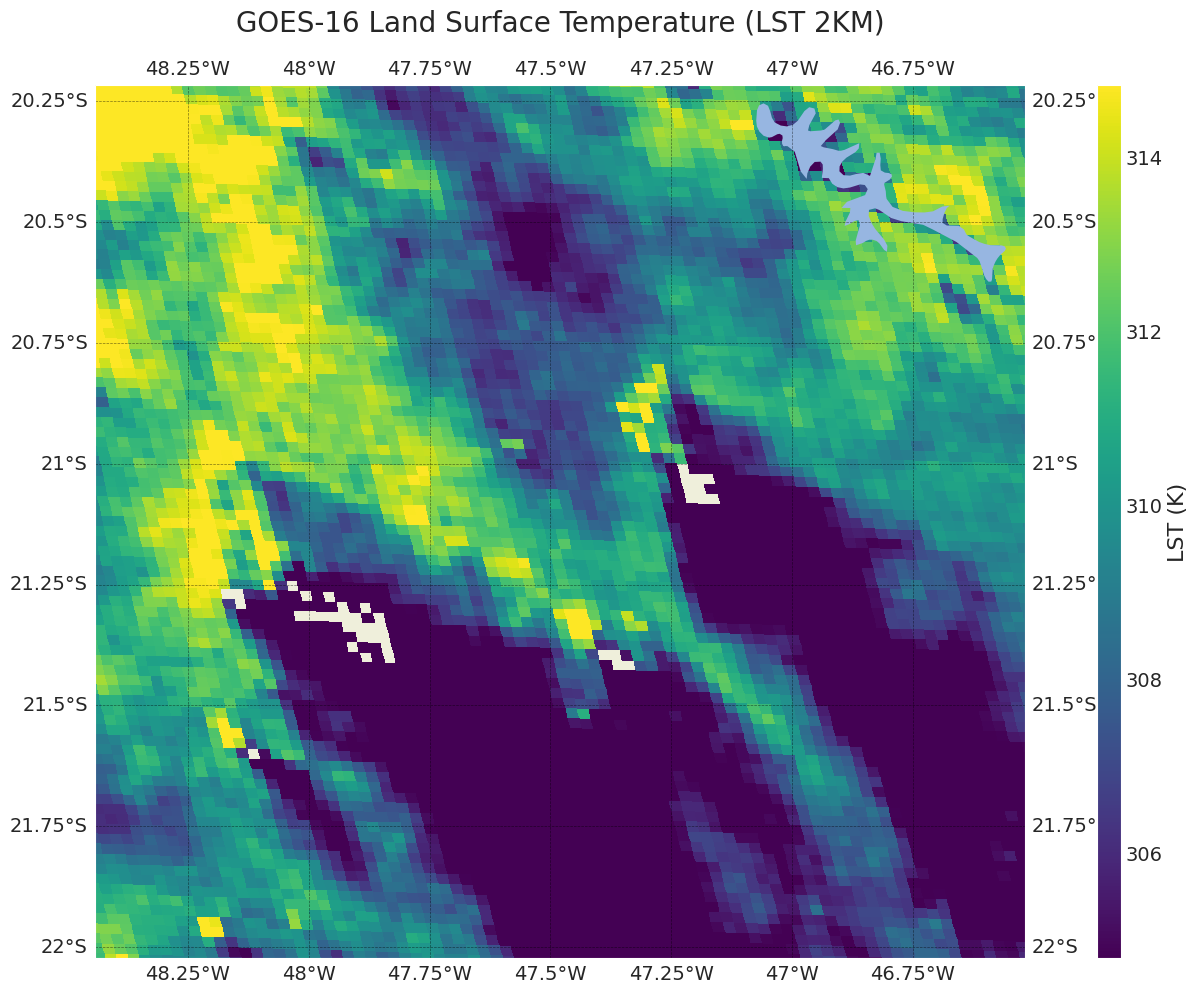

In [ ]:
files = fs.ls('noaa-goes16/ABI-L2-LST2KMF/2024/236/18')

with fs.open(files[0], 'rb') as f:
    ds = xr.open_dataset(BytesIO(f.read()), engine='h5netcdf')
    sat_h = ds.goes_imager_projection.perspective_point_height #coletando altura do satelite
    sat_lon = ds.goes_imager_projection.longitude_of_projection_origin #coletando longitude do satelite (fixa)
    sat_sweep = ds.goes_imager_projection.sweep_angle_axis[0] #coletando angulo de varredura para
    oproj=ccrs.Geostationary(central_longitude=sat_lon,satellite_height=sat_h,sweep_axis=sat_sweep) #criando projecao

    X = np.array(ds.x) * sat_h
    Y = np.array(ds.y) * sat_h
    temp = np.array(ds.LST) #armazendando temperatura

    #lst = ds['LST']
    #lst_values = lst.values

    fig = plt.figure(num=1,figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1, projection=newproj)
    im = ax.pcolormesh(X, Y, temp, transform=oproj, cmap='viridis', vmin=vminimum,vmax=vmaximum)

    ax.coastlines(resolution='110m')
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=1.0)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-',linewidth=1.0)
    ax.add_feature(cartopy.feature.LAKES)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=geo)

    gl=ax.gridlines(crs=newproj,draw_labels=True,linewidth=0.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter = LongitudeFormatter
    gl.yformatter = LatitudeFormatter
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    cb = fig.colorbar(im,cax=cax, orientation="vertical", shrink=0.7,pad=0.02)
    #cb.ax.set_yticklabels(ticklabellist[j])
    cb.ax.tick_params(size=0,labelsize=14)
    cb.set_label('LST (K)', fontsize=16)

    ax.set_title('GOES-16 Land Surface Temperature (LST 2KM)', fontsize=20, pad=20)

    plt.show()

#display(ds.LST)

## 4. Analisando ano a ano

In [ ]:
i=213
valid_days=0
temp_list = []
while i<=244:

  files = fs.ls(f'noaa-goes16/ABI-L2-LST2KMF/2022/{i}/15') #list of data files
  #print(files)

  lat, lon, data = getgoes(files[0], "LST")
  data = data[box]
  lat = lat[box]
  lon = lon[box]

  data_df = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
  data_df.columns = ['lst','lat','lon']

  if data_df['lst'].isna().sum() < 0.7*maximum_pixel:
    #print(1 - (data_df['lst'].isna().sum()/int(vnum)))
    valid_days+=1
    temp_list.append(data_df['lst'].mean())
  else:
    temp_list.append(np.nan)

  i+=1
print(f"valid={valid_days}")
print(f"mean list for valid days={temp_list}")
print(f"mean august 2022={np.mean(temp_list)}")
print(f"std={np.std(temp_list)}")

valid=25
mean list for valid days=[309.59296, 310.2704, 310.26712, 308.7346, 311.13675, 312.82535, 311.46646, nan, nan, nan, 297.94485, 306.03107, 309.892, 310.70346, 310.50803, 308.85233, nan, 309.46872, nan, nan, 308.49472, 309.57227, 311.5377, 308.60175, nan, 309.85724, 312.16187, 314.8539, 307.74655, 304.40637, 309.27322, 311.86792]
mean august 2022=nan
std=nan


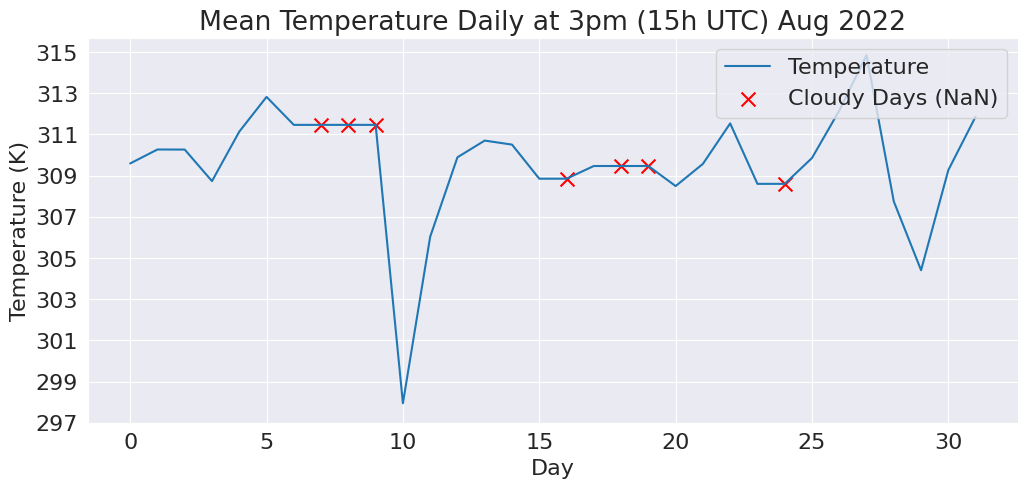

In [ ]:
# temp_list is list of temperature values for August 2022
temp_list = np.array(temp_list)

# Convert temp_list to a pandas Series to use forward-fill
temp_series = pd.Series(temp_list)

# Forward fill NaN values for plotting
temp_filled = temp_series.ffill().values

# Plot the filled temperature data
plt.figure(figsize=(12, 5))
plt.plot(temp_filled, label='Temperature')

# Highlight originally NaN values
nan_indices = np.where(np.isnan(temp_list))[0]
plt.scatter(nan_indices, temp_filled[nan_indices], color='red', marker='x', s=100, label='Cloudy Days (NaN)')

# Set Y-axis ticks with 1 K intervals
y_min = np.floor(np.min(temp_filled))  # Minimum temperature rounded down
y_max = np.ceil(np.max(temp_filled))   # Maximum temperature rounded up
plt.yticks(np.arange(y_min, y_max + 2, 2))  # Set ticks at every 2K interval

# Add titles and labels
plt.title("Mean Temperature Daily at 3pm (15h UTC) Aug 2022")
plt.xlabel("Day")
plt.ylabel("Temperature (K)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

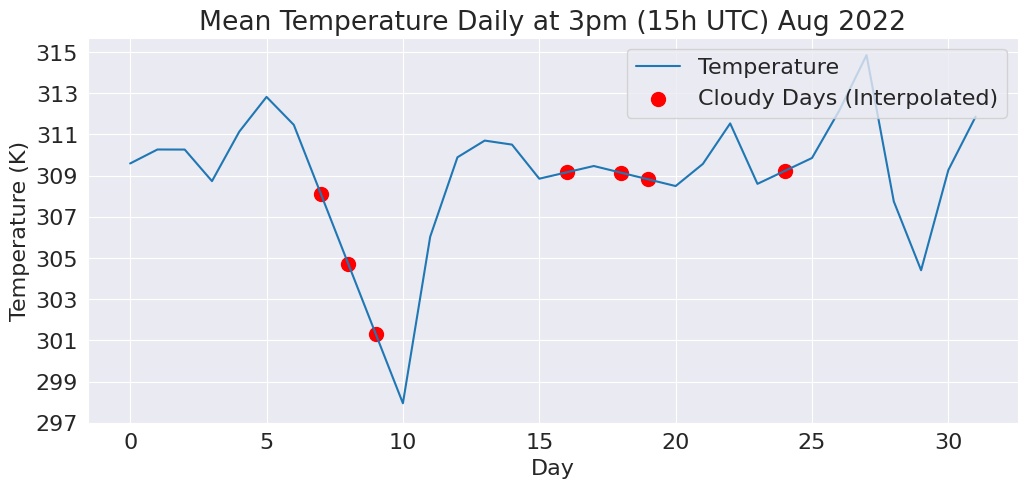

In [ ]:
# temp_list is list of temperature values for August 2022
temp_list = np.array(temp_list)

# Convert temp_list to a pandas Series
temp_series = pd.Series(temp_list)

# Interpolating
df_interpolated = temp_series.interpolate(method='linear')

# Plot the filled temperature data
plt.figure(figsize=(12, 5))
plt.plot(df_interpolated, label='Temperature')

# Highlight originally NaN values
nan_indices = np.where(np.isnan(temp_list))[0]
plt.scatter(nan_indices, df_interpolated[nan_indices], color='red', marker='o', s=100, label='Cloudy Days (Interpolated)')

# Set Y-axis ticks with 1 K intervals
y_min = np.floor(np.min(df_interpolated))  # Minimum temperature rounded down
y_max = np.ceil(np.max(df_interpolated))   # Maximum temperature rounded up
plt.yticks(np.arange(y_min, y_max + 2, 2))  # Set ticks at every 2K interval

# Add titles and labels
plt.title("Mean Temperature Daily at 3pm (15h UTC) Aug 2022")
plt.xlabel("Day")
plt.ylabel("Temperature (K)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### 4.2. Agosto entre 2022 e 2024

In [ ]:
y=2022
temp_dict = {}
valid_days_list = []
while y<=2024:
  d=213
  temp_list = []
  valid_days=0
  while d<=244:
    files = fs.ls(f'noaa-goes16/ABI-L2-LST2KMF/{y}/{d}/14') #list of data files
    #print(files)

    lat, lon, data = getgoes(files[0], "LST")
    data = data[box]
    lat = lat[box]
    lon = lon[box]

    data_df = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
    data_df.columns = ['lst','lat','lon']

    if data_df['lst'].isna().sum() < 0.7*maximum_pixel:
      #print(1 - (data_df['lst'].isna().sum()/int(vnum)))
      valid_days+=1
      temp_list.append(data_df['lst'].mean())
    else:
      temp_list.append(np.nan)
    d+=1
  temp_dict[y] = temp_list
  valid_days_list.append(valid_days)
  y+=1

In [ ]:
print(temp_dict)
print(valid_days_list)
df_temp = pd.DataFrame(temp_dict)
mean_dic = {2022: df_temp[2022].mean(),
            2023:df_temp[2023].mean(),
            2024:df_temp[2024].mean()}
display(df_temp)

{2022: [306.5317, 307.8126, 307.70837, 305.9981, 308.78976, 309.16345, 308.98727, nan, nan, nan, 294.50217, 302.63666, 306.21432, 307.34885, 307.37277, 306.11948, nan, 308.32532, nan, nan, 303.79175, 306.5551, 308.31192, nan, 308.6502, 308.12073, 310.55286, 312.8375, 306.12027, 302.0697, 305.83124, 308.25717], 2023: [305.50916, 306.8096, 307.37717, 307.4697, 308.18433, 308.09702, 308.3091, 307.7727, 305.7807, 307.13077, 309.06076, 308.484, 305.79132, 304.80197, nan, nan, 307.85413, 308.053, 306.20062, 302.5618, 305.4841, 309.9253, 310.98392, nan, 309.52176, 305.6892, nan, 292.4304, nan, 303.89673, nan, 308.84164], 2024: [304.7657, 306.3342, 305.4815, 304.06647, 304.3627, 308.27652, 308.39368, 308.23276, 309.89938, 304.8274, nan, 300.32486, nan, 302.9962, 305.8384, 309.08325, 311.49936, 312.32837, 313.40247, 312.78027, 313.0937, 312.2692, 312.6652, 312.50793, 310.75598, nan, 298.8359, 306.73816, 307.92334, 310.83295, 312.73816, 314.09448]}
[25, 26, 29]


2022        2023        2024
0   306.531708  305.509155  304.765686
1   307.812592  306.809601  306.334198
2   307.708374  307.377167  305.481506
3   305.998108  307.469696  304.066467
4   308.789764  308.184326  304.362701
5   309.163452  308.097015  308.276520
6   308.987274  308.309113  308.393677
7          NaN  307.772705  308.232758
8          NaN  305.780701  309.899384
9          NaN  307.130768  304.827393
10  294.502167  309.060760         NaN
11  302.636658  308.484009  300.324860
12  306.214325  305.791321         NaN
13  307.348846  304.801971  302.996185
14  307.372772         NaN  305.838409
15  306.119476         NaN  309.083252
16         NaN  307.854126  311.499359
17  308.325317  308.053009  312.328369
18         NaN  306.200623  313.402466
19         NaN  302.561798  312.780273
20  303.791748  305.484100  313.093689
21  306.555115  309.925293  312.269196
22  308.311920  310.983917  312.665192
23         NaN         NaN  312.507935
24  308.650208  309.521759  310.755981
25  308.120728  305.689209         NaN
26  310.552856         NaN  298.835907
27  312.837494  292.430389  306.738159
28  306.120270         NaN  307.923340
29  302.069702  303.896729  310.832947
30  305.831238         NaN  312.738159
31  308.257172  308.841644  314.094482

In [ ]:
df_temp.describe()

2022        2023        2024
count   25.000000   26.000000   29.000000
mean   306.744371  306.616189  308.460291
std      3.428723    3.465420    4.122912
min    294.502167  292.430389  298.835907
25%    306.119476  305.712082  305.481506
50%    307.372772  307.423431  308.393677
75%    308.325317  308.277916  312.328369
max    312.837494  310.983917  314.094482

In [ ]:
df_temp.isna().sum()

2022    7
2023    6
2024    3
dtype: int64

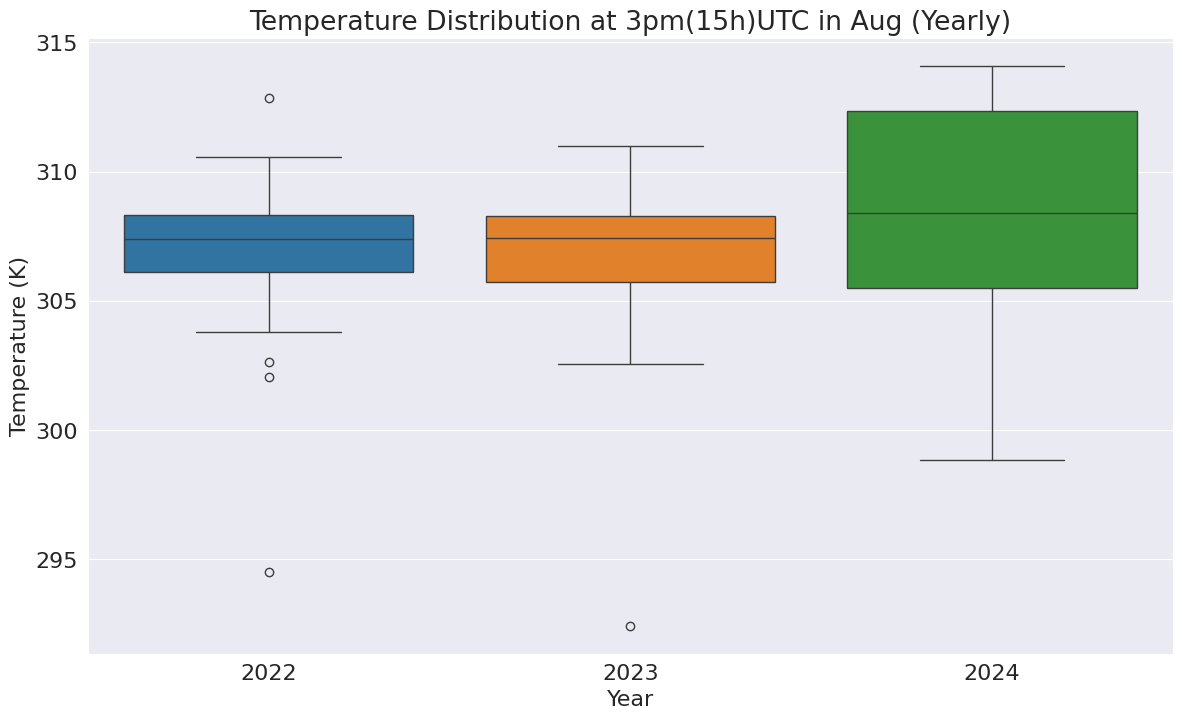

In [ ]:
plt.figure(figsize=(14, 8))

# Plotting box plot
sns.boxplot(df_temp)

plt.title("Temperature Distribution at 3pm(15h)UTC in Aug (Yearly)")
plt.xlabel("Year")
plt.ylabel("Temperature (K)")
plt.show()


É um problema físico complexo devido a atenuação da radiação que chega a superfície, mas não necessariamente isso reflete a temperatura atmosférica.

Como são áreas grandes cobertas pelo fogo, tempos temperaturas mais baixas de solo

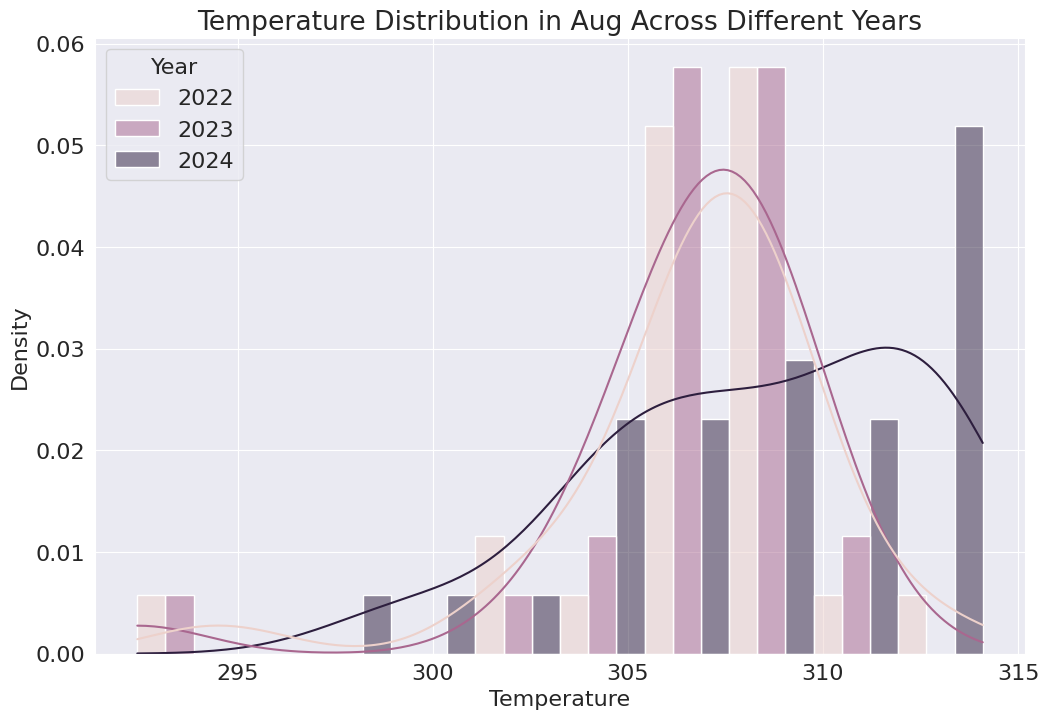

In [ ]:
# Melt the dataframe to have 'Year' and 'Temperature' as variables
df_melted = df_temp.melt(var_name='Year', value_name='Temperature')

# Create histograms with KDE for each year
plt.figure(figsize=(12, 8))
sns.histplot(data=df_melted, x='Temperature', hue='Year', multiple='dodge', bins=10, kde=True, stat='density')
plt.title('Temperature Distribution in Aug Across Different Years')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Aumentar tamnanho dos canais

### 4.3. Analisando NaN

<ipython-input-65-1721f5bbd48a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_temp.fillna(method='ffill')


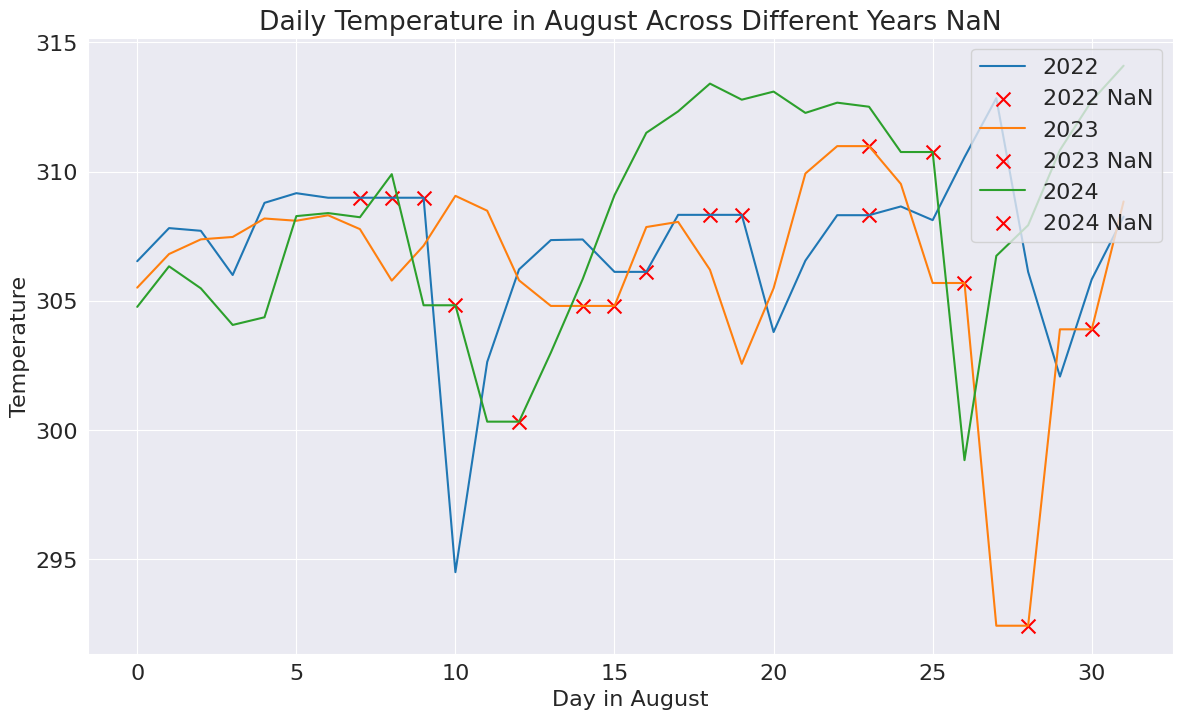

In [ ]:
# Forward fill NaN values
df_filled = df_temp.fillna(method='ffill')

# Create line plots for each year, highlighting originally NaN values
plt.figure(figsize=(14, 8))

for year in df_temp.columns:
    # Plot the temperature data
    plt.plot(df_temp.index, df_filled[year], label=year)

    # Highlight originally NaN values
    nan_indices = df_temp[df_temp[year].isna()].index
    plt.scatter(nan_indices, df_filled.loc[nan_indices, year], color='red', marker='x', s=100, label=f'{year} NaN')

plt.title('Daily Temperature in August Across Different Years NaN')
plt.xlabel('Day in August')
plt.ylabel('Temperature')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### 4.4. Interpolação de NaN preenchendo com média de valor anterior e posterior

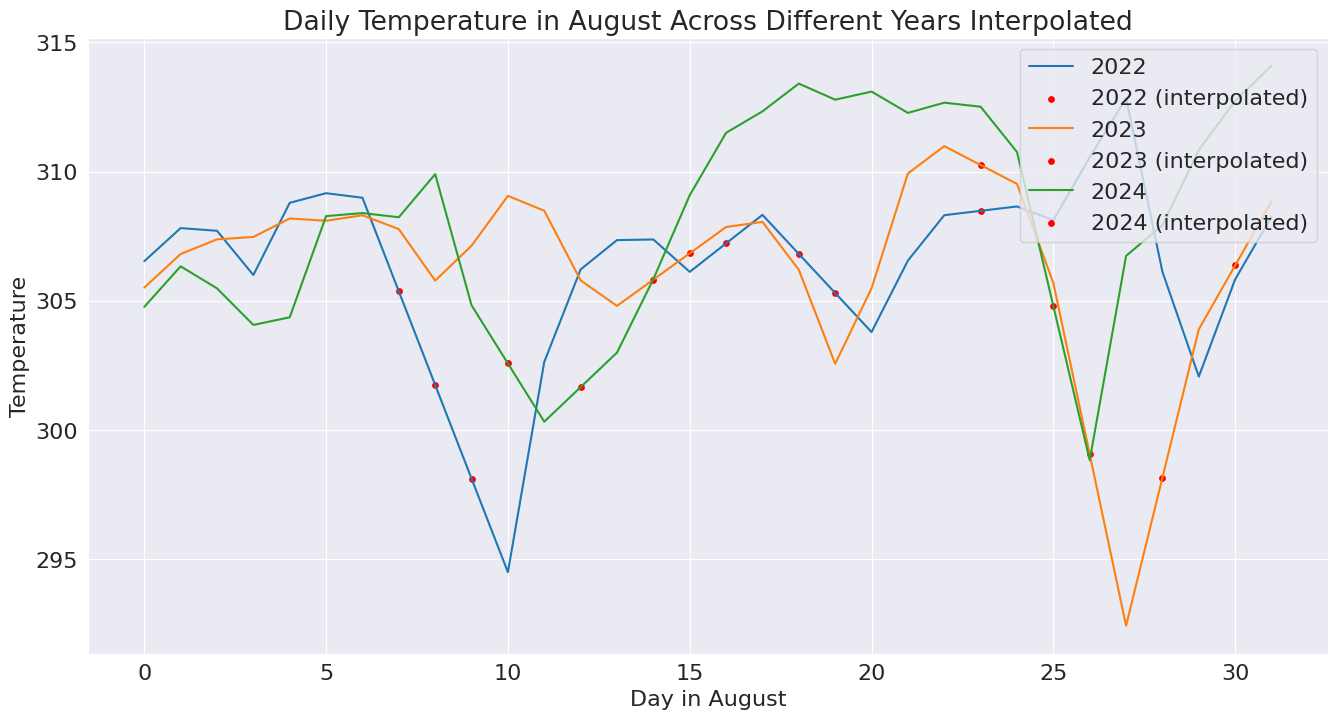

In [ ]:
df_interpolated = df_temp.interpolate(method='linear')

plt.figure(figsize=(16, 8))

for year in df_temp.columns:
    # Plot the temperature data
    plt.plot(df_temp.index, df_interpolated[year], label=year)

    # Highlight interpolated NaN values
    nan_indices = df_temp[df_temp[year].isna()].index
    plt.scatter(nan_indices, df_interpolated.loc[nan_indices, year], color='red', marker='o', s=15, label=f'{year} (interpolated)')

plt.title('Daily Temperature in August Across Different Years Interpolated')
plt.xlabel('Day in August')
plt.ylabel('Temperature')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## 5. Analisando os anos entre 2022 e 2024

Para o código ser viável computacionalmente, usaremos o LSTF com precisão de 10km ao invés de 2km para ganharmos velocidade computacional

In [ ]:
files = fs.ls(f'noaa-goes16/ABI-L2-LSTF/2022/225/15') #list of data files
lat, lon, data = getgoes(files[0], "LST")

# Lat/Lon coordinates
# Coordinates for middle of Ribeirao Preto
latsite = -21.12
lonsite = -47.48

# Box side length in km. E.g. 100 means a 100 x 100 km² box (~1 x 1 deg)
boxsize = 200

geod   = Geodesic.WGS84  # define the WGS84 ellipsoid
north  = geod.Direct(latsite, lonsite,  0.0, boxsize/2.*1e3) #calculating box from its center defined by latsite and lonsite
east   = geod.Direct(latsite, lonsite, 90.0, boxsize/2.*1e3)
south  = geod.Direct(latsite, lonsite, 180.0, boxsize/2.*1e3)
west   = geod.Direct(latsite, lonsite, 270.0, boxsize/2.*1e3)
minlat = np.min([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
maxlat = np.max([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
minlon = np.min([north['lon2'],east['lon2'],south['lon2'],west['lon2']])
maxlon = np.max([north['lon2'],east['lon2'],south['lon2'],west['lon2']])

print(f"minlat={minlat}")
print(f"maxlat={maxlat}")
print(f"minlon={minlon}")
print(f"maxlon={maxlon}")

box = (lat >= minlat) & (lat <= maxlat) & (lon >= minlon) & (lon <= maxlon)

minlat=-22.02314204267506
maxlat=-20.21676177358013
minlon=-48.44257190584565
maxlon=-46.51742809415435


In [ ]:
y=2022
temp_dict = {}
valid_days_list = []
while y<=2024:
  d=1
  temp_list = []
  valid_days=0
  while d<=244:
    d_string = str(d)
    if len(d_string) == 1:
        d_string = '00' + d_string
    elif len(d_string) == 2:
        d_string = '0' + d_string
    else:
        d_string = d_string

    try:
      files = fs.ls(f'noaa-goes16/ABI-L2-LSTF/{y}/{d_string}/15') #list of data files
      #print(files)

      lat, lon, data = getgoes(files[0], "LST")
      data = data[box]
      lat = lat[box]
      lon = lon[box]

      data_df_yearly = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
      data_df_yearly.columns = ['lst','lat','lon']

      if data_df_yearly['lst'].isna().sum() < 0.7*maximum_pixel:
        #print(1 - (data_df['lst'].isna().sum()/int(vnum)))
        valid_days+=1
        temp_list.append(data_df_yearly['lst'].mean())
      else:
        temp_list.append(np.nan)
      d+=1

    except:
      temp_list.append(np.nan)
      print(f'Ano: {y} Dia: {d} arquivo não encontrado')
      d+=1

  temp_dict[y] = temp_list
  valid_days_list.append(valid_days)
  y+=1

Ano: 2022 Dia: 64 arquivo não encontrado
Ano: 2022 Dia: 77 arquivo não encontrado
Ano: 2022 Dia: 108 arquivo não encontrado
Ano: 2022 Dia: 144 arquivo não encontrado
Ano: 2022 Dia: 153 arquivo não encontrado
Ano: 2022 Dia: 197 arquivo não encontrado
Ano: 2024 Dia: 46 arquivo não encontrado


<ipython-input-69-c5d7a8ee9b77>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  default_colormap = plt.cm.get_cmap('tab10', len(df_temp_yearly.columns))


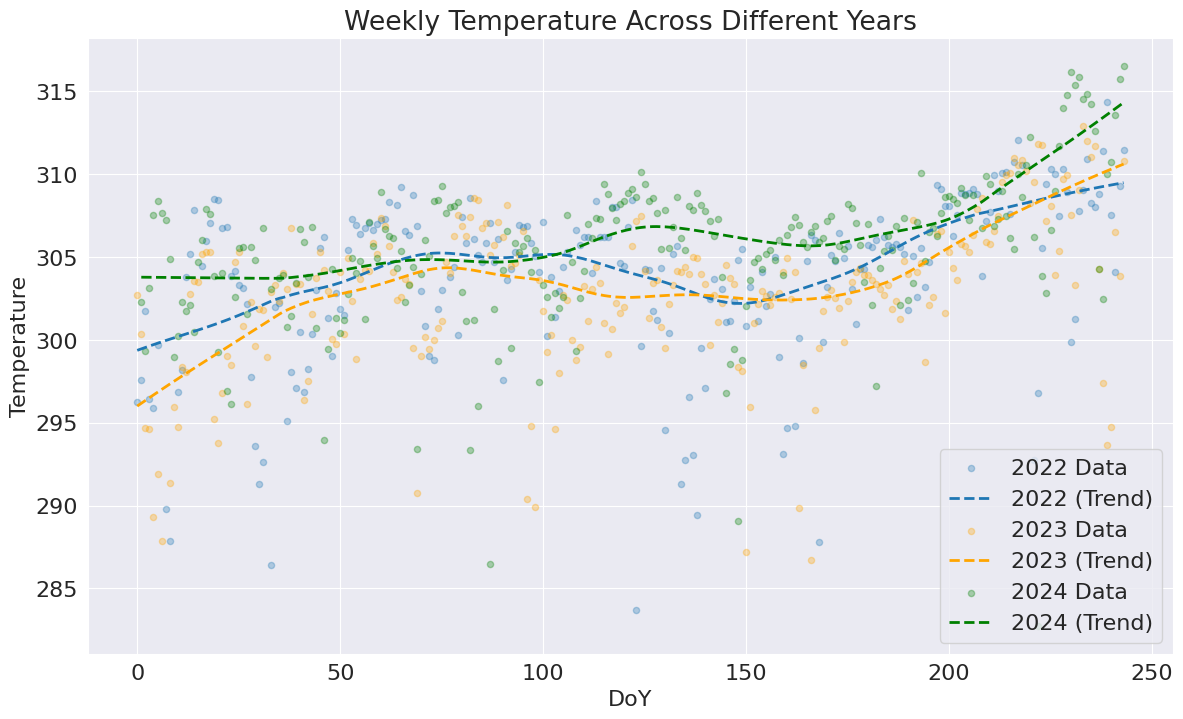

In [ ]:
import statsmodels.api as sm

# Assuming temp_dict is your temperature data dictionary
df_temp_yearly = pd.DataFrame(temp_dict)

# Interpolating missing values linearly
df_interpolated = df_temp_yearly.interpolate(method='linear')

# Create the plot with a larger figure size
plt.figure(figsize=(14, 8))

# Predefine colors for specific years
color_map = {
    2022: '#1f77b4',
    2023: 'orange',
    2024: 'green'
}

# Default colormap for other years
default_colormap = plt.cm.get_cmap('tab10', len(df_temp_yearly.columns))

for i, year in enumerate(df_temp_yearly.columns):
    # Get the color for the specific year or default color
    color = color_map.get(int(year), default_colormap(i))

    # Scatterplot with transparency (alpha)
    plt.scatter(df_temp_yearly.index, df_temp_yearly[year],
                color=color, alpha=0.3, s=20, label=f'{year} Data')

    # LOWESS smoothing to create the tendency line (fraction controls smoothness)
    lowess = sm.nonparametric.lowess(df_interpolated[year], df_temp_yearly.index, frac=0.3)

    # Plot the LOWESS smoothed line
    plt.plot(lowess[:, 0], lowess[:, 1], color=color, linewidth=2, linestyle='--', label=f'{year} (Trend)')

# Add title and labels
plt.title('Weekly Temperature Across Different Years')
plt.xlabel('DoY')
plt.ylabel('Temperature')
plt.legend(loc='lower right', fontsize='medium')
plt.grid(True)

# Show the plot
plt.show()


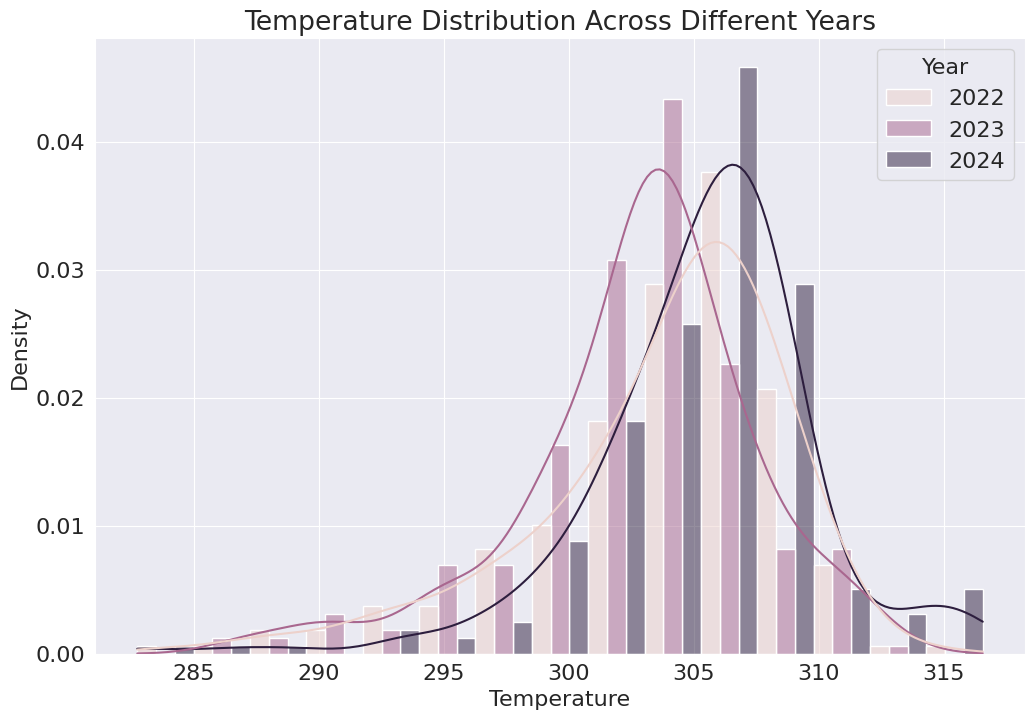

In [ ]:
# Melt the dataframe to have 'Year' and 'Temperature' as variables
df_melted = df_temp_yearly.melt(var_name='Year', value_name='Temperature')

# Create histograms with KDE for each year
plt.figure(figsize=(12, 8))
sns.histplot(data=df_melted, x='Temperature', hue='Year', multiple='dodge', bins=15, kde=True, stat='density')
plt.title('Temperature Distribution Across Different Years')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.grid(True)
plt.show()

é difícil dizer exatamente o motivo das temperaturas inferiores em 2023, como uma área é pequena muito sujeita a variações

Harp - para fazer o TrueColor

Ao longo do ano: valor médio com barra de incerteza para caracterizar melhor outros meses

Vapor d'água - trazer toda atmosfera pro nível do mar e vê altura da coluna em cm


# 6. Vapor d'agua

In [ ]:
files = fs.ls(f'noaa-goes16/ABI-L2-TPWF/2022/225/15') #list of data files
lat, lon, data = getgoes(files[0], "TPW")

# Lat/Lon coordinates
# Coordinates for middle of Ribeirao Preto
latsite = -21.12
lonsite = -47.48

# Box side length in km. E.g. 100 means a 100 x 100 km² box (~1 x 1 deg)
boxsize = 200

geod   = Geodesic.WGS84  # define the WGS84 ellipsoid
north  = geod.Direct(latsite, lonsite,  0.0, boxsize/2.*1e3) #calculating box from its center defined by latsite and lonsite
east   = geod.Direct(latsite, lonsite, 90.0, boxsize/2.*1e3)
south  = geod.Direct(latsite, lonsite, 180.0, boxsize/2.*1e3)
west   = geod.Direct(latsite, lonsite, 270.0, boxsize/2.*1e3)
minlat = np.min([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
maxlat = np.max([north['lat2'],east['lat2'],south['lat2'],west['lat2']])
minlon = np.min([north['lon2'],east['lon2'],south['lon2'],west['lon2']])
maxlon = np.max([north['lon2'],east['lon2'],south['lon2'],west['lon2']])

print(f"minlat={minlat}")
print(f"maxlat={maxlat}")
print(f"minlon={minlon}")
print(f"maxlon={maxlon}")

box = (lat >= minlat) & (lat <= maxlat) & (lon >= minlon) & (lon <= maxlon)

minlat=-22.02314204267506
maxlat=-20.21676177358013
minlon=-48.44257190584565
maxlon=-46.51742809415435


In [ ]:
i=213
valid_days=0
temp_list = []
while i<=244:

  files = fs.ls(f'noaa-goes16/ABI-L2-TPWF/2022/{i}/15') #list of data files
  #print(files)

  lat, lon, data = getgoes(files[0], "TPW")
  data = data[box]
  lat = lat[box]
  lon = lon[box]

  data_df = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
  data_df.columns = ['TPW','lat','lon']

  if data_df['TPW'].isna().sum() < 0.7*maximum_pixel:
    #print(1 - (data_df['lst'].isna().sum()/int(vnum)))
    valid_days+=1
    temp_list.append(data_df['TPW'].mean())
  else:
    temp_list.append(np.nan)

  i+=1
print(f"valid={valid_days}")
print(f"mean list for valid days={temp_list}")
print(f"mean august 2022={np.mean(temp_list)}")
print(f"std={np.std(temp_list)}")

valid=32
mean list for valid days=[17.846098, 17.347456, 16.386696, 18.141794, 19.428823, 22.53518, 19.785545, nan, nan, 11.532061, 12.226432, 10.018157, 11.98624, 13.414087, 10.374446, 18.046482, 22.184776, 21.800335, 27.911774, 26.888063, 25.929897, 20.907118, 15.179167, 17.184723, 16.957996, 17.713194, 15.0644245, 15.112629, 23.391628, 23.973454, 14.817023, 12.304818]
mean august 2022=nan
std=nan


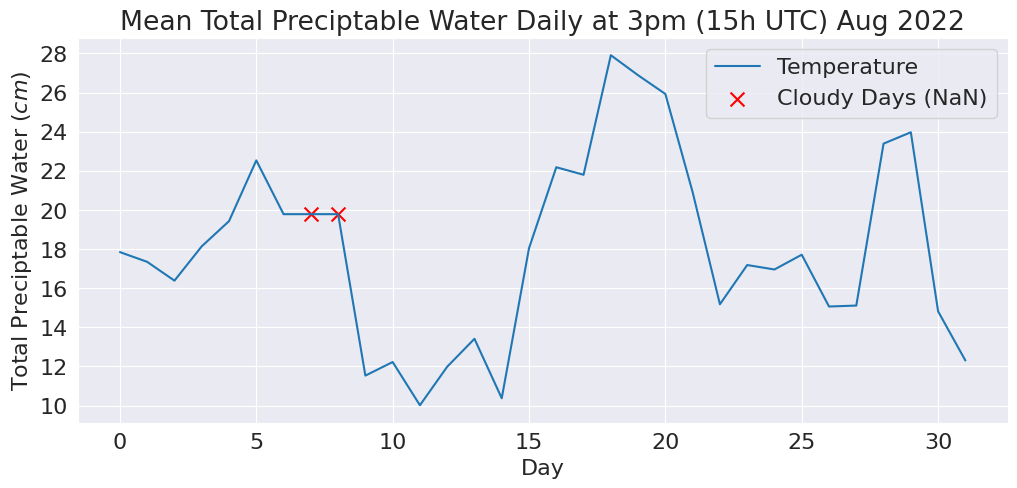

In [ ]:
# temp_list is list of temperature values for August 2022
temp_list = np.array(temp_list)

# Convert temp_list to a pandas Series to use forward-fill
temp_series = pd.Series(temp_list)

# Forward fill NaN values for plotting
temp_filled = temp_series.ffill().values

# Plot the filled temperature data
plt.figure(figsize=(12, 5))
plt.plot(temp_filled, label='Temperature')

# Highlight originally NaN values
nan_indices = np.where(np.isnan(temp_list))[0]
plt.scatter(nan_indices, temp_filled[nan_indices], color='red', marker='x', s=100, label='Cloudy Days (NaN)')

# Set Y-axis ticks with 1 K intervals
y_min = np.floor(np.min(temp_filled))  # Minimum temperature rounded down
y_max = np.ceil(np.max(temp_filled))   # Maximum temperature rounded up
plt.yticks(np.arange(y_min, y_max + 2, 2))  # Set ticks at every 2cm interval

# Add titles and labels
plt.title("Mean Total Preciptable Water Daily at 3pm (15h UTC) Aug 2022")
plt.xlabel("Day")
plt.ylabel("Total Preciptable Water ($cm$)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
y=2022
temp_dict = {}
valid_days_list = []
while y<=2024:
  d=213
  temp_list = []
  valid_days=0
  while d<=244:
    files = fs.ls(f'noaa-goes16/ABI-L2-TPWF/{y}/{d}/14') #list of data files
    #print(files)

    lat, lon, data = getgoes(files[0], "TPW")
    data = data[box]
    lat = lat[box]
    lon = lon[box]

    data_df = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
    data_df.columns = ['TPW','lat','lon']

    if data_df['TPW'].isna().sum() < 0.7*maximum_pixel:
      valid_days+=1
      temp_list.append(data_df['TPW'].mean())
    else:
      temp_list.append(np.nan)
    d+=1
  temp_dict[y] = temp_list
  valid_days_list.append(valid_days)
  y+=1

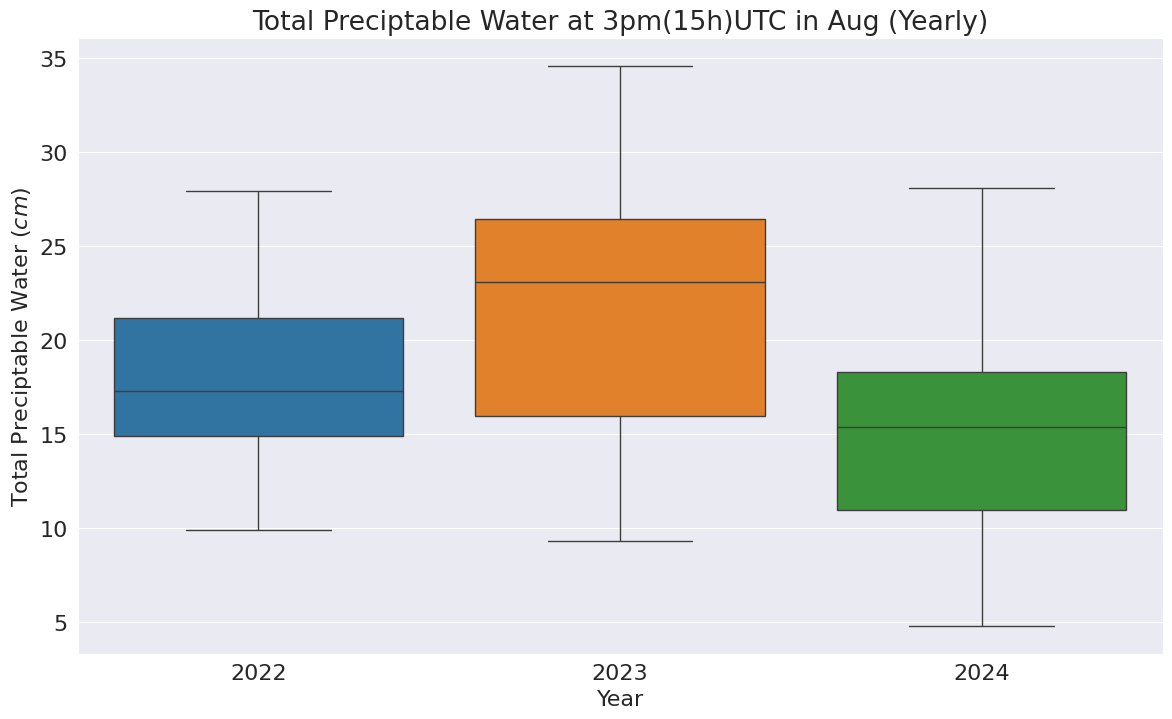

In [ ]:
df_temp = pd.DataFrame(temp_dict)
mean_dic = {2022: df_temp[2022].mean(),
            2023:df_temp[2023].mean(),
            2024:df_temp[2024].mean()}
#display(df_temp)

plt.figure(figsize=(14, 8))

# Plotting box plot
sns.boxplot(df_temp)

plt.title("Total Preciptable Water at 3pm(15h)UTC in Aug (Yearly)")
plt.xlabel("Year")
plt.ylabel("Total Preciptable Water ($cm$)")
plt.show()


<ipython-input-76-3a98fe382a0f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_temp.fillna(method='ffill')


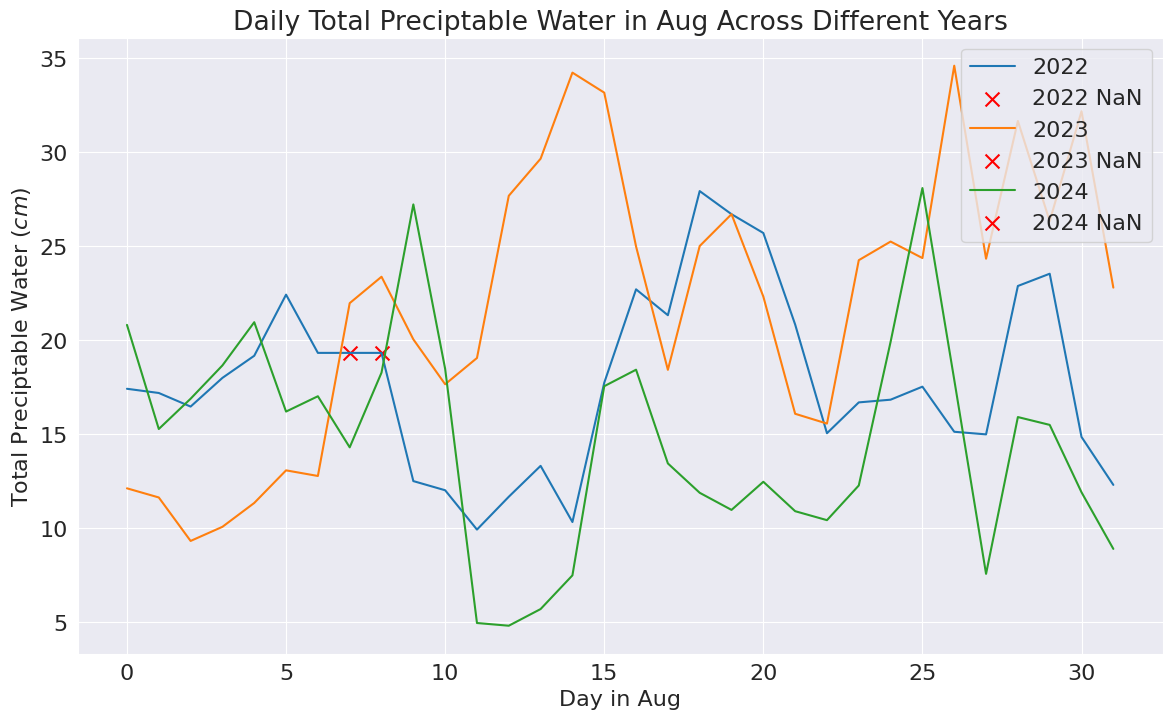

In [ ]:
# Forward fill NaN values
df_filled = df_temp.fillna(method='ffill')

# Create line plots for each year, highlighting originally NaN values
plt.figure(figsize=(14, 8))

for year in df_temp.columns:
    # Plot the temperature data
    plt.plot(df_temp.index, df_filled[year], label=year)

    # Highlight originally NaN values
    nan_indices = df_temp[df_temp[year].isna()].index
    plt.scatter(nan_indices, df_filled.loc[nan_indices, year], color='red', marker='x', s=100, label=f'{year} NaN')

plt.title('Daily Total Preciptable Water in Aug Across Different Years')
plt.xlabel('Day in Aug')
plt.ylabel('Total Preciptable Water ($cm$)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Ajustar as cores pra ficar igual o outro

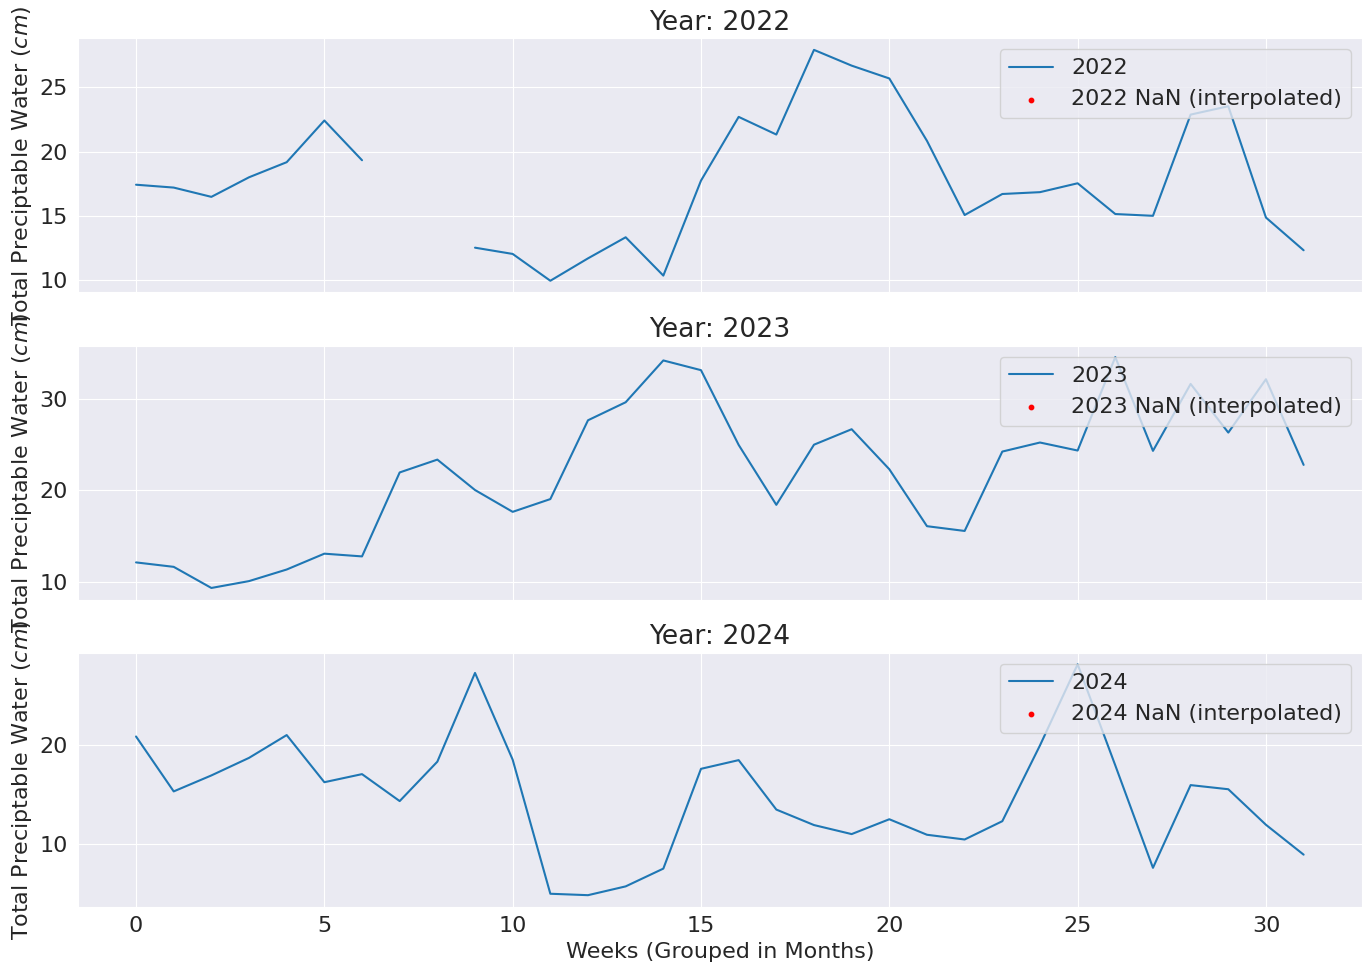

In [ ]:
# Define the number of years (columns) and their names
years = df_temp.columns
num_years = len(years)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_years, 1, figsize=(14, 10), sharex=True)

# Plot each year's data in a separate subplot
for i, year in enumerate(years):
    axs[i].plot(df_temp.index, df_temp[year], label=year)

    # Highlight interpolated NaN values
    nan_indices = df_temp[df_temp[year].isna()].index
    axs[i].scatter(nan_indices, df_temp.loc[nan_indices, year], color='red', marker='o', s=10, label=f'{year} NaN (interpolated)')

    # Set title, labels, and legend
    axs[i].set_title(f'Year: {year}')
    axs[i].set_ylabel('Total Preciptable Water ($cm$)')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Weeks (Grouped in Months)')

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
y=2022
temp_dict = {}
valid_days_list = []
while y<=2024:
  d=1
  temp_list = []
  valid_days=0
  while d<=244:
    d_string = str(d)
    if len(d_string) == 1:
        d_string = '00' + d_string
    elif len(d_string) == 2:
        d_string = '0' + d_string
    else:
        d_string = d_string

    try:
      files = fs.ls(f'noaa-goes16/ABI-L2-TPWF/{y}/{d_string}/15') #list of data files
      #print(files)

      lat, lon, data = getgoes(files[0], "TPW")
      data = data[box]
      lat = lat[box]
      lon = lon[box]

      data_df_yearly = pd.concat([pd.DataFrame(data),pd.DataFrame(lat),pd.DataFrame(lon)], axis=1)
      data_df_yearly.columns = ['TPW','lat','lon']

      if data_df_yearly['TPW'].isna().sum() < 0.7*maximum_pixel:
        valid_days+=1
        temp_list.append(data_df_yearly['TPW'].mean())
      else:
        temp_list.append(np.nan)
      d+=1

    except:
      temp_list.append(np.nan)
      print(f'Ano: {y} Dia: {d} arquivo não encontrado')
      d+=1

  temp_dict[y] = temp_list
  valid_days_list.append(valid_days)
  y+=1

Ano: 2022 Dia: 64 arquivo não encontrado
Ano: 2022 Dia: 77 arquivo não encontrado
Ano: 2022 Dia: 144 arquivo não encontrado
Ano: 2024 Dia: 164 arquivo não encontrado


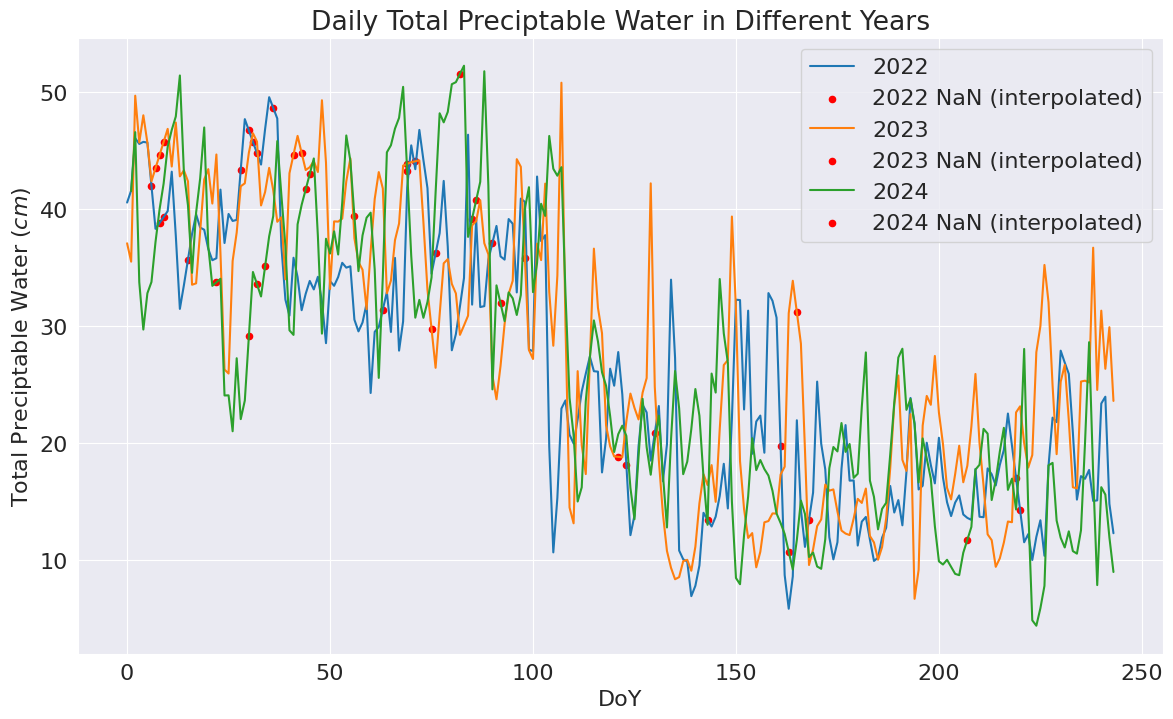

In [ ]:
df_temp_yearly = pd.DataFrame(temp_dict)

df_interpolated = df_temp_yearly.interpolate(method='linear')

plt.figure(figsize=(14, 8))

for year in df_temp_yearly.columns:
    # Plot the temperature data
    plt.plot(df_temp_yearly.index, df_interpolated[year], label=year)

    # Highlight interpolated NaN values
    nan_indices = df_temp_yearly[df_temp_yearly[year].isna()].index
    plt.scatter(nan_indices, df_interpolated.loc[nan_indices, year], color='red', marker='o', s=20, label=f'{year} NaN (interpolated)')


plt.title('Daily Total Preciptable Water in Different Years')
plt.xlabel('DoY')
plt.ylabel('Total Preciptable Water ($cm$)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

<ipython-input-80-265bb8557ebe>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  default_colormap = plt.cm.get_cmap('tab10', len(df_temp_yearly.columns))


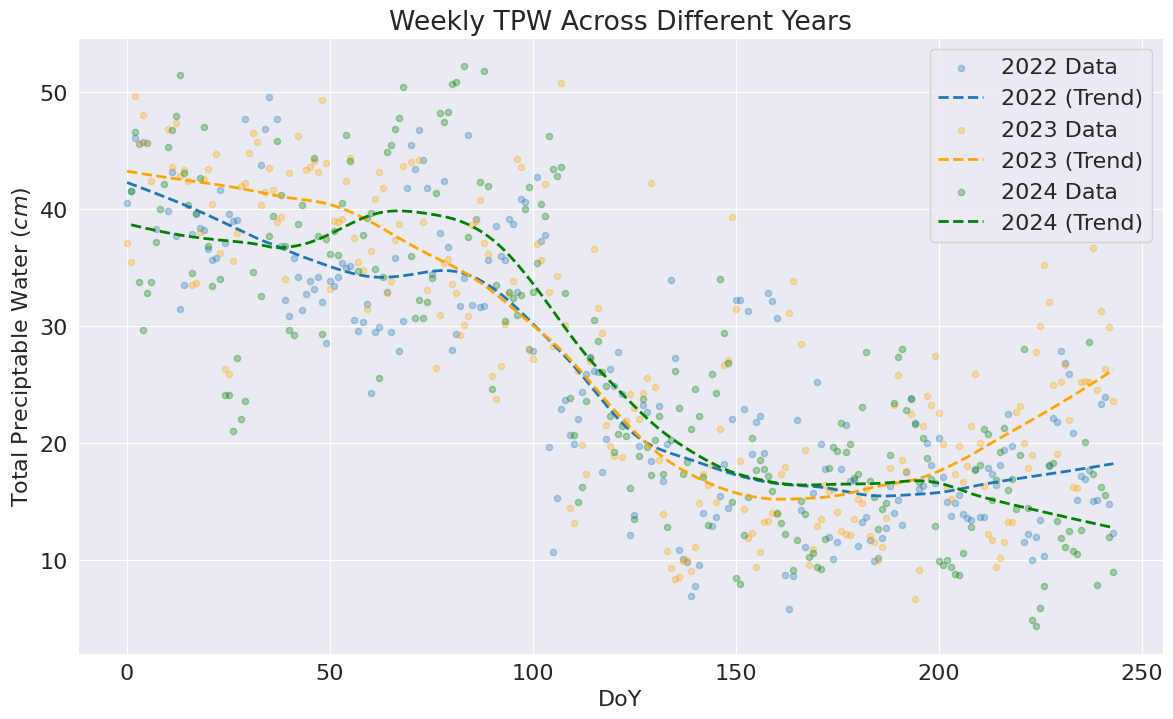

In [ ]:
# Assuming temp_dict is your temperature data dictionary
df_temp_yearly = pd.DataFrame(temp_dict)

# Interpolating missing values linearly
df_interpolated = df_temp_yearly.interpolate(method='linear')

# Create the plot with a larger figure size
plt.figure(figsize=(14, 8))

# Predefine colors for specific years
color_map = {
    2022: '#1f77b4',
    2023: 'orange',
    2024: 'green'
}

# Default colormap for other years
default_colormap = plt.cm.get_cmap('tab10', len(df_temp_yearly.columns))

for i, year in enumerate(df_temp_yearly.columns):
    # Get the color for the specific year or default color
    color = color_map.get(int(year), default_colormap(i))

    # Scatterplot with transparency (alpha)
    plt.scatter(df_temp_yearly.index, df_temp_yearly[year],
                color=color, alpha=0.3, s=20, label=f'{year} Data')

    # LOWESS smoothing to create the tendency line (fraction controls smoothness)
    lowess = sm.nonparametric.lowess(df_interpolated[year], df_temp_yearly.index, frac=0.3)

    # Plot the LOWESS smoothed line
    plt.plot(lowess[:, 0], lowess[:, 1], color=color, linewidth=2, linestyle='--', label=f'{year} (Trend)')

# Add title and labels
plt.title('Weekly TPW Across Different Years')
plt.xlabel('DoY')
plt.ylabel('Total Preciptable Water ($cm$)')
plt.legend(loc='upper right', fontsize='medium')
plt.grid(True)

# Show the plot
plt.show()

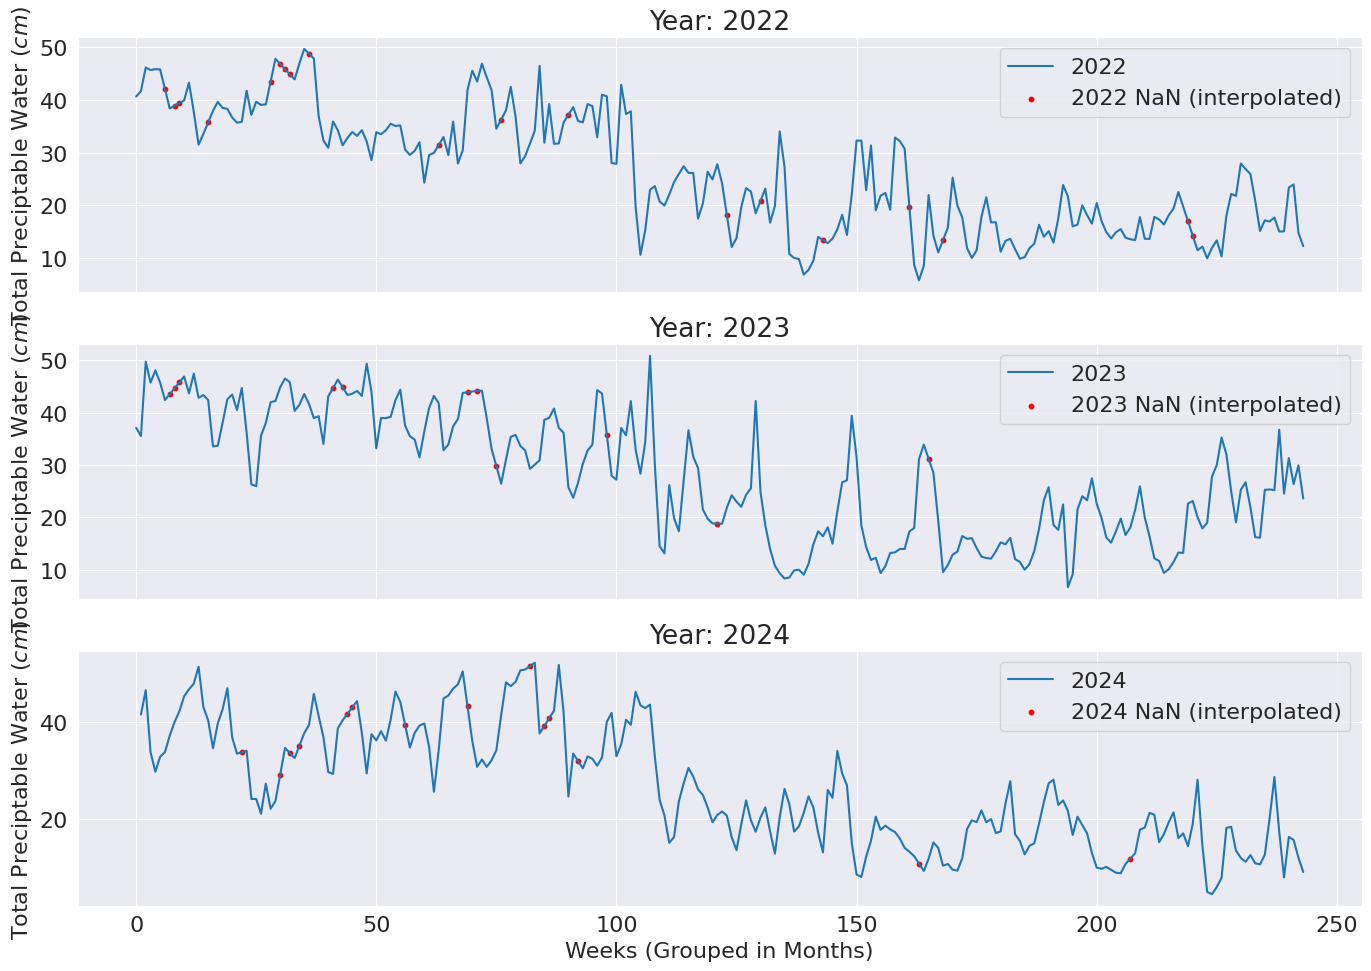

In [ ]:
# Define the number of years (columns) and their names
years = df_temp_yearly.columns
num_years = len(years)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_years, 1, figsize=(14, 10), sharex=True)

# Plot each year's data in a separate subplot
for i, year in enumerate(years):
    axs[i].plot(df_temp_yearly.index, df_interpolated[year], label=year)

    # Highlight interpolated NaN values
    nan_indices = df_temp_yearly[df_temp_yearly[year].isna()].index
    axs[i].scatter(nan_indices, df_interpolated.loc[nan_indices, year], color='red', marker='o', s=10, label=f'{year} NaN (interpolated)')

    # Set title, labels, and legend
    axs[i].set_title(f'Year: {year}')
    axs[i].set_ylabel('Total Preciptable Water ($cm$)')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Weeks (Grouped in Months)')

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()